In [21]:
import numpy as np
from scipy.optimize import fsolve, least_squares
import matplotlib.pyplot as plt

In [2]:
# Define parameters
p1, q1 = 0, 0
p2, q2 = 1, 0
p3, q3 = 0, 1
delta1 = 0.5
delta2 = 0.3

In [3]:
# Define system of equations representing the 2D GPS model
def system(vars):
    x, y = vars
    eq1 = np.sqrt((x - p1)**2 + (y - q1)**2) - np.sqrt((x - p2)**2 + (y - q2)**2) - delta1
    eq2 = np.sqrt((x - p2)**2 + (y - q2)**2) - np.sqrt((x - p3)**2 + (y - q3)**2) - delta2
    return [eq1, eq2]

In [4]:
# Provide an initial guess
initial_guess = [0.5, 0.5]

In [5]:
# Solve the system numerically
solution = fsolve(system, initial_guess)

In [6]:
# Output the solution
x_sol, y_sol = solution
print(f"Solution: x = {x_sol:.4f}, y = {y_sol:.4f}")

Solution: x = 3.5139, y = 5.2023


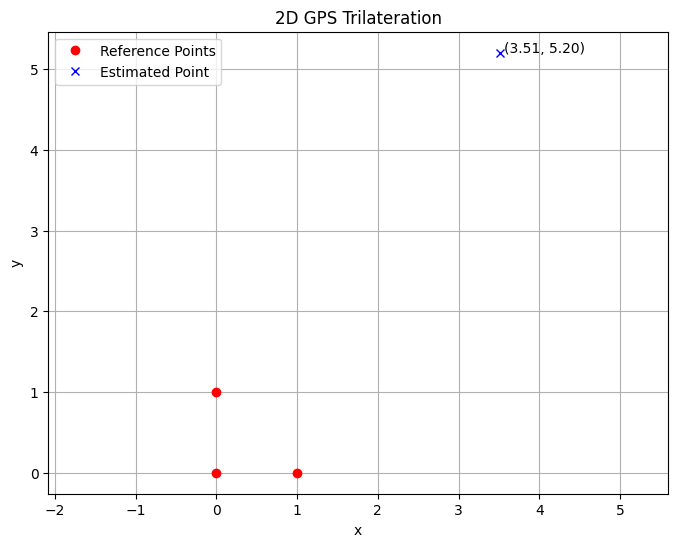

In [7]:

# Plot the locations and the estimated point
plt.figure(figsize=(8, 6))
plt.plot([p1, p2, p3], [q1, q2, q3], 'ro', label='Reference Points')
plt.plot(x_sol, y_sol, 'bx', label='Estimated Point')
plt.text(x_sol + 0.05, y_sol, f'({x_sol:.2f}, {y_sol:.2f})')
plt.legend()
plt.title("2D GPS Trilateration")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.axis("equal")
plt.show()

In [8]:
# Define the known positions of the reference points (anchors)
p1 = np.array([0.0, 0.0])
p2 = np.array([4.0, 0.0])
p3 = np.array([2.0, 3.0])

In [9]:
# Define the measured distances (can be noisy in practice)
delta1 = 2.5
delta2 = 2.0

In [10]:
# Define the system of equations
def equations(vars):
    x, y = vars
    eq1 = np.sqrt((x - p1[0])**2 + (y - p1[1])**2) - np.sqrt((x - p2[0])**2 + (y - p2[1])**2) - delta1
    eq2 = np.sqrt((x - p2[0])**2 + (y - p2[1])**2) - np.sqrt((x - p3[0])**2 + (y - p3[1])**2) - delta2
    return [eq1, eq2]


In [11]:
# Initial guess
initial_guess = [1.0, 1.0]


In [12]:
# Solve the system
solution = fsolve(equations, initial_guess)
x_sol, y_sol = solution

C:\Users\bcift\AppData\Local\Temp\ipykernel_17400\2514152260.py:2: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  solution = fsolve(equations, initial_guess)


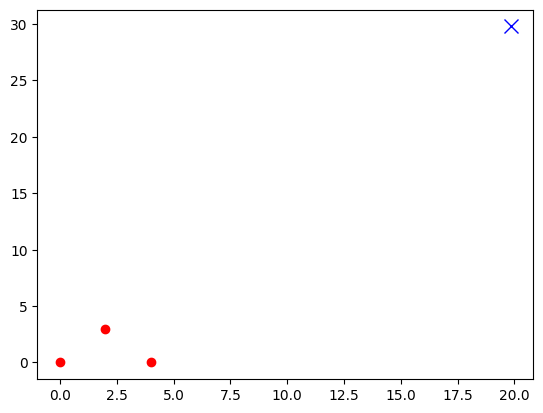

In [13]:
# Visualization
fig, ax = plt.subplots()
ax.plot([p1[0], p2[0], p3[0]], [p1[1], p2[1], p3[1]], 'ro', label='Reference Points')
ax.plot(x_sol, y_sol, 'bx', label='Estimated Position', markersize=10)

In [15]:
solution

array([19.83919468, 29.78852398])

In [16]:
speed_of_signal = 3e8  # meters per second (speed of light)
delta1_m = delta1 * speed_of_signal
delta2_m = delta2 * speed_of_signal

In [ ]:
# Fix random seed for reproducibility
np.random.seed(42)

In [ ]:
beacons = np.array([
    [0, 0],
    [1, 0],
    [0, 1],
    [1, 1]
])
deltas = np.array([0.2, -0.1, 0.05])  # len = len(beacons) - 1

In [18]:
noise = np.random.normal(0, 1e-9, size=3)  # nanosecond-level noise
delta1_noisy = delta1 + noise[0]

#### Full residuals_3d Function

In [ ]:
def residuals_3d(vars, beacons, deltas, c=3e8):
    x, y, z = vars
    p = np.array([x, y, z])
    
    r0 = np.linalg.norm(p - beacons[0])  # distance to first beacon

    residuals = []
    for i in range(1, len(beacons)):
        ri = np.linalg.norm(p - beacons[i])
        delta_dist = c * deltas[i - 1]  # convert time delta to distance
        residuals.append((r0 - ri) - delta_dist)

    return np.array(residuals)

In [22]:
# Define beacons in 3D space
beacons = np.array([
    [0, 0, 0],
    [1000, 0, 0],
    [0, 1000, 0],
    [0, 0, 1000]
])

# Assume real position of the object
true_pos = np.array([300, 400, 500])

# Compute true distances
true_dists = np.linalg.norm(beacons - true_pos, axis=1)

# Simulate time delays (with beacon[0] as reference)
c = 3e8
deltas = (true_dists[1:] - true_dists[0]) / c  # time differences

# Initial guess
initial_guess = [0, 0, 0]

# Solve
result = least_squares(residuals_3d, initial_guess, args=(beacons, deltas, c))
estimated_pos = result.x

print("Estimated Position:", estimated_pos)
print("True Position:", true_pos)

Estimated Position: [734.33097612 632.92407822 500.        ]
True Position: [300 400 500]


## Mimics a 4-variable GPS solver

In [23]:
# Fix random seed for reproducibility
np.random.seed(42)

# Define beacons in 3D space
beacons = np.array([
    [0, 0, 0],
    [1000, 0, 0],
    [0, 1000, 0],
    [0, 0, 1000]
])

In [24]:
# True position of the object
true_pos = np.array([300, 400, 500])
true_clock_bias = 5e-9  # 5 nanoseconds

# Speed of light
c = 3e8

In [25]:
# Compute true distances and include clock bias
true_dists = np.linalg.norm(beacons - true_pos, axis=1) + c * true_clock_bias

# Simulate noisy time delays (relative to beacon[0])
deltas = (true_dists[1:] - true_dists[0]) / c
noise = np.random.normal(0, 1e-9, size=deltas.shape)  # 1 nanosecond std dev
noisy_deltas = deltas + noise

# Global list to store positions for visualization
positions = []

In [26]:
# Define the residuals function including clock bias
def residuals_with_bias(vars, beacons, deltas, c=3e8):
    x, y, z, b = vars  # clock bias in seconds
    p = np.array([x, y, z])
    positions.append(p.copy())  # Track the optimization path
    r0 = np.linalg.norm(p - beacons[0]) + c * b
    residuals = []
    for i in range(1, len(beacons)):
        ri = np.linalg.norm(p - beacons[i]) + c * b
        delta_dist = c * deltas[i - 1]
        residuals.append((r0 - ri) - delta_dist)
    return np.array(residuals)

In [27]:
# Initial guess (including clock bias)
initial_guess = [0, 0, 0, 0]

# Solve with least squares
result = least_squares(
    residuals_with_bias,
    initial_guess,
    args=(beacons, noisy_deltas, c),
    verbose=0
)

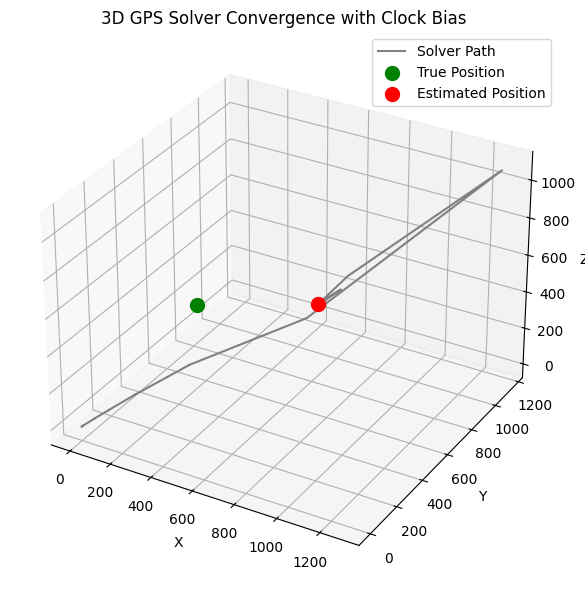

In [28]:
# Prepare data for animation
positions = np.array(positions)
final_position = result.x[:3]
true_position = true_pos

# Plot convergence path
plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.plot3D(positions[:, 0], positions[:, 1], positions[:, 2], 'gray', label='Solver Path')
ax.scatter(*true_position, color='green', label='True Position', s=100)
ax.scatter(*final_position, color='red', label='Estimated Position', s=100)
ax.set_title("3D GPS Solver Convergence with Clock Bias")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.tight_layout()
plt.show()